# Practice 4. Constrained Optimization: Equality Constraints
Authors: Marc Ballestero and Iris Vukovic

First of all, let us implement a function to perform descent. This function performs a Newton step wherever the Hessian matrix is positive-definite, and a basic gradient descent with backtracking otherwise.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from types import LambdaType
def newton_descent(x0, lamb0, f, grad_f, hess_f, h, grad_h, alpha_0, z_tol=1e-6, max_iters=1000000, max_backtracking_iters=1000):

  x = x0
  lamb = lamb0
  n_iters_conv = 0
  converged = False

  x_path = [x]
  lamb_path = [lamb]

  while not converged:

    # Check if max iterations have been reached
    if n_iters_conv >= max_iters:
        print(f"Maximum number of iterations reached. No minimum could be reached.")
        print(f"N = {n_iters_conv}")
        break

    alpha = alpha_0
    x = x.flatten()  # Ensure x is 1-dimensional
    lamb = lamb.flatten() if isinstance(lamb, np.ndarray) else lamb # Reshape only if lamb is a numpy array

    eigs, _ = np.linalg.eig(hess_f(x, lamb))
    n_iters_back = 0

    if np.all(eigs > 0):

      # Construct the LHS matrx
      A_top_left = hess_f(x, lamb)  # ∇²ₓₓ L(xk, λk)
      A_top_right = -grad_h(x).reshape(-1, 1)  # -∇h(xk) reshaped to a column vector
      A_bottom_left = -grad_h(x).T  # ∇h(xk)ᵀ
      A_bottom_right = np.zeros((grad_h(x).reshape(-1, 1).shape[1], grad_h(x).reshape(-1, 1).shape[1]))  # Zero matrix

      A = np.block([[A_top_left, A_top_right], [A_bottom_left, A_bottom_right]])

      # Construct the RHS vector
      b_top = -grad_f(x, lamb).reshape(-1, 1)  # -∇ₓ L(xk, λk) as column vector
      b_bottom = np.array([[h(x)]])  # h(xk)

      b = np.concatenate([b_top, b_bottom])

      # Solving the linear system
      try:
          solution = np.linalg.solve(A, b)
      except np.linalg.LinAlgError:
          print("Failed to solve linear system.")
          break

      # Extract d_k and v_k from the solution vector
      d_k = solution[:hess_f(x, lamb).shape[0]]  # The first part corresponds to d_k
      v_k = solution[hess_f(x, lamb).shape[0]:]  # The second part corresponds to ν_k

      # Ensure d_k is a 1D array (flatten if necessary)
      d_k = d_k.flatten()

      #print(f'd_k:{d_k}, v_k:{v_k}')

      xp = x + alpha * d_k
      lambp = lamb + alpha * v_k

      f_decreased = np.all(f(xp, lambp) < f(x, lamb))
      while not f_decreased:
        alpha /= 2
        xp = x + alpha * d_k
        lambp = lamb + alpha * v_k

        f_decreased = np.all(f(xp, lambp) < f(x, lamb))

        n_iters_back += 1

        if n_iters_back >= max_iters:
          print("Maximum number of iterations reached. No step could be computed.")
          break

        if np.abs(alpha) < z_tol:
          print("Step size too small. No step could be computed.")
          print("final step size: ", alpha)
          print()
          break

      # Check if we broke the loop before updating the solution
      if n_iters_back >= max_iters:
        break

      if np.abs(alpha) < z_tol:
        break

      x = xp
      lamb = lambp

      x_path.append(x.flatten())
      lamb_path.append(lamb.flatten())

    else:
      print("Hessian is not positive-definite. Trying gradient descent.")
      xp = x - alpha * grad_f(x, lamb)
      lambp = lamb + alpha * h(x)  #updating lambda with constraint function's value


      f_decreased = np.all(f(xp, lambp) < f(x, lamb))
      while not f_decreased:
        alpha /= 2
        xp = x - alpha * grad_f(x, lamb)
        lambp = lamb + alpha * h(x)

        f_decreased = np.all(f(xp, lambp) < f(x, lamb))

        n_iters_back += 1

        if n_iters_back >= max_iters:
          print("Maximum number of iterations reached. No step could be computed.")
          break

        if np.abs(alpha) < z_tol:
          print("Step size too small. No step could be computed.")
          print("final step size: ", alpha)
          print()
          break

      # Check if we broke the loop before updating the solution
      if n_iters_back >= max_backtracking_iters:
        break

      if np.abs(alpha) < z_tol:
        break

      x = xp
      lamb = lambp

      x_path.append(x.flatten())
      lamb_path.append(lamb.flatten())

    converged = np.linalg.norm(grad_f(x, lamb)) < z_tol

    n_iters_conv += 1

    '''if n_iters_conv >= max_iters:
      print(f"Maximum number of iterations reached. No minimum could be reached.")
      print(f"N = {n_iters_conv}")
      break'''

  # Convert to numpy arrays when done
  x_path = np.vstack(x_path)  # Stack along rows to form a 2D array
  lamb_path = np.vstack(lamb_path)  # Stack along rows to form a 2D array

  return x, lamb, x_path, lamb_path

####(1) Sequential Quadratic Optimization with step size $\alpha_k = 1$.

Here, we implement the solution of the first experiment, using the Newton-gradient combined descent.


In [ ]:
#define objective function
def f(x: np.ndarray):
  return np.e ** (3*x[0]) + np.e ** (-4*x[1])

#define constraint function
def h(x: np.ndarray):
  return x[0]**2 + x[1]**2 -1

#define gradients of f and h
def gradf(x: np.ndarray):
  return np.array([3*np.e**(3*x[0]), -4*np.e**(-4*x[1])])

def gradh(x: np.ndarray):
  return np.array([2*x[0], 2*x[1]])

#define hessians of f and h
def hessf(x: np.ndarray):
  return np.array([[9*np.e**(3*x[0]), 0], [0, 16*np.e**(-4*x[1])]])

def hessh(x: np.ndarray):
  return np.array([[2, 0], [0, 2]])

#define Lagrangian function
def L(x: np.ndarray, lamb: np.ndarray):
  return f(x) - lamb*h(x)

#define gradients of L
def gradL(x: np.ndarray, lamb: np.ndarray):
  return gradf(x) - lamb*gradh(x)

#define hessians of L
def hessL(x: np.ndarray, lamb: np.ndarray):
  return hessf(x) - lamb*hessh(x)


#starting points
x0 = np.array([-1., 1.])
lamb0 = -1.
alpha = 1

xstar, lambstar, xpath, lambpath = newton_descent(x0, lamb0, L, gradL, hessL, h, gradh, alpha_0=alpha)
print('x*: ',xstar)
print("lamb*: ",lambstar)

x*:  [-0.74833549  0.66332043]
lamb*:  [[-0.21232494]]


Expected result reached. The following plot shows the descent path

xpath:  [[-1.          1.        ]
 [-0.77422564  0.72577436]
 [-0.74864523  0.66613893]
 [-0.74833818  0.66332345]
 [-0.74833549  0.66332043]]

lambpath:  [[-1.        ]
 [-0.35103786]
 [-0.21605873]
 [-0.2123239 ]
 [-0.21232494]]
0.0028142148045688714 2.0


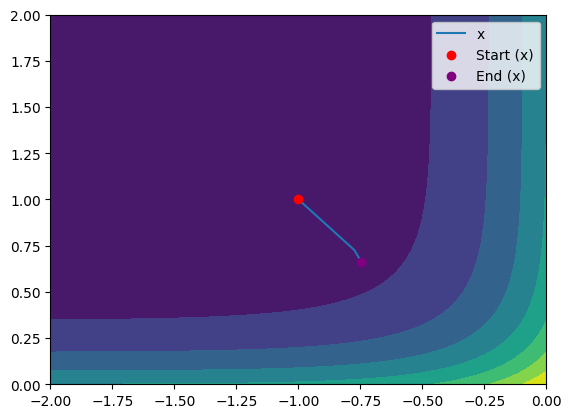

In [ ]:
print('xpath: ', xpath)
print()
print('lambpath: ', lambpath)

#plot the path
fig, ax = plt.subplots()


x1_range = np.linspace(-2, 0, num=200)
x2_range = np.linspace(0, 2, num=200)

xx1, xx2 = np.meshgrid(x1_range, x2_range)
z = f([xx1, xx2])
print(z.min(), z.max())

ax.contourf(xx1, xx2, z)

ax.plot(xpath[:, 0], xpath[:, 1], label = 'x')
#ax.plot(lambpath[:, 0], label = 'lambda')

# Mark the starting and ending points for x (red for start, purple for end)
ax.scatter(x0[0], x0[1], color='red', label='Start (x)', zorder=5)  # Red point for start of x
ax.scatter(xstar[0], xstar[1], color='purple', label='End (x)', zorder=5)  # Purple point for end of x

plt.legend()

As we can see, convergence has been quick.

#### (2) Now to experiment with some starting points farther from the optimal solution.

For starting point  [-2  2] :

Step size too small. No step could be computed.
final step size:  9.5367431640625e-07

x*:  [-0.75389144  0.6654764 ]
lamb*:  [-0.20244439]

xpath:  [[-2.          2.        ]
 [-1.13019359  1.11980641]
 [-0.83100487  0.73803435]
 [-0.75389144  0.6654764 ]]

lambpath:  [[-1.        ]
 [-0.44161335]
 [-0.20175012]
 [-0.20244439]]



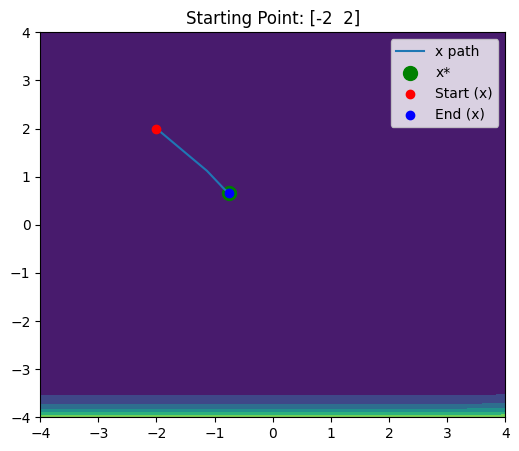

For starting point  [-1.5  1.5] :

Step size too small. No step could be computed.
final step size:  9.5367431640625e-07

x*:  [-0.74876872  0.66374185]
lamb*:  [-0.21121476]

xpath:  [[-1.5         1.5       ]
 [-0.93082229  0.90251104]
 [-0.77728484  0.68360837]
 [-0.74876872  0.66374185]]

lambpath:  [[-1.        ]
 [-0.40952978]
 [-0.21176489]
 [-0.21121476]]



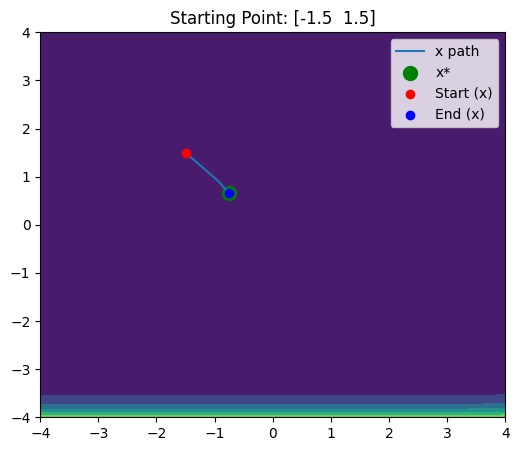

For starting point  [2 2] :

Hessian is not positive-definite. Trying gradient descent.
Hessian is not positive-definite. Trying gradient descent.
Hessian is not positive-definite. Trying gradient descent.
Hessian is not positive-definite. Trying gradient descent.
x*:  [ 0.91041323 -0.41370006]
lamb*:  [[25.2938552]]

xpath:  [[ 2.          2.        ]
 [ 1.66606813  0.58393187]
 [ 1.32690186 -0.26086806]
 [ 1.04208321 -0.12120379]
 [ 0.98994262 -0.15437887]
 [ 0.94525808 -0.17397771]
 [ 1.00667232 -0.22867616]
 [ 0.92957874 -0.27335917]
 [ 1.03681043 -0.3801106 ]
 [ 0.92376929 -0.39976874]
 [ 0.9106855  -0.41353678]
 [ 0.91041338 -0.41369986]
 [ 0.91041323 -0.41370006]]

lambpath:  [[-1.        ]
 [-0.71026968]
 [-2.47858373]
 [ 8.27938274]
 [28.08540732]
 [28.08546699]
 [28.08308515]
 [28.08411143]
 [28.08220024]
 [24.50818957]
 [25.27591284]
 [25.2938486 ]
 [25.2938552 ]]



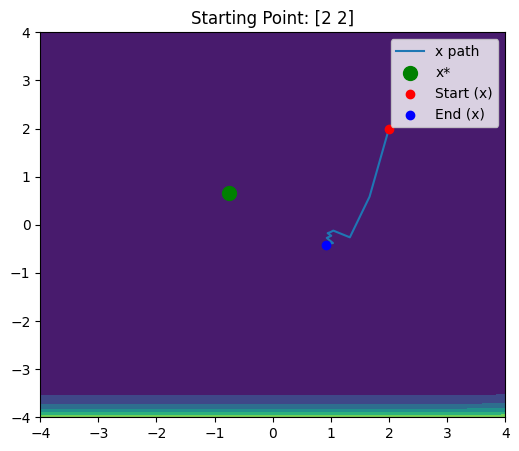

For starting point  [1 1] :

Step size too small. No step could be computed.
final step size:  9.5367431640625e-07

x*:  [-0.80291097  0.64747267]
lamb*:  [-0.16013809]

xpath:  [[ 1.          1.        ]
 [ 0.66780806  0.83219194]
 [ 0.33727749  1.01421181]
 [ 0.00241636  1.05537705]
 [-0.328774    1.00220837]
 [-0.64280614  0.84305725]
 [-0.80291097  0.64747267]]

lambpath:  [[-1.        ]
 [-0.22902743]
 [ 0.02667387]
 [-0.02958612]
 [-0.03521839]
 [-0.06488542]
 [-0.16013809]]



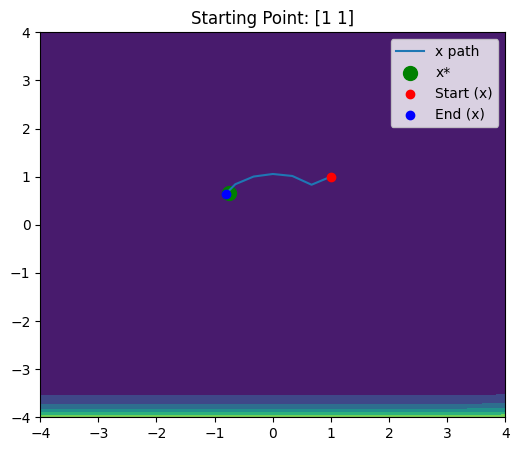

In [ ]:
#starting points
x0s = [np.array([-2, 2]),
       np.array([-1.5, 1.5]),
       np.array([2, 2]),
       np.array([1, 1])]

lamb0 = -1.
alpha = 1

for x0 in x0s:
  print('For starting point ', x0 ,':')
  print()
  xstar, lambstar, xpath, lambpath = newton_descent(x0, lamb0, L, gradL, hessL, h, gradh, alpha_0=alpha)
  print('x*: ',xstar)
  print("lamb*: ",lambstar)
  print()
  print('xpath: ', xpath)
  print()
  print('lambpath: ', lambpath)
  print()

  # Plotting the graph under the printed information
  fig, ax = plt.subplots(figsize=(6, 5))  # Create a new figure for each starting point

  #optimal point
  x_ = np.array([-0.74833549, 0.66332043])

  x1_range = np.linspace(-4, 4, num=200)
  x2_range = np.linspace(-4, 4, num=200)

  xx1, xx2 = np.meshgrid(x1_range, x2_range)
  z = f([xx1, xx2])

  ax.contourf(xx1, xx2, z)  # Plot the contour
  ax.plot(xpath[:, 0], xpath[:, 1], label='x path')  # Plot the x path
  ax.scatter(x_[0], x_[1], color='green', s=100, label="x*")  # Plot the point x*

  # Mark the starting and ending points for x (red for start, purple for end)
  ax.scatter(x0[0], x0[1], color='red', label='Start (x)', zorder=5)  # Red point for start of x
  ax.scatter(xstar[0], xstar[1], color='blue', label='End (x)', zorder=5)  # Purple point for end of x

  ax.set_title(f'Starting Point: {x0}')
  ax.legend()

  plt.show()


The problem never quite converges the farther away we get from the optimal solution, but it gets relatively close to the optimal answer, except in the case of $(2,2)$ where Newton descent can't even be implemented because the hessian isn't positive definite. In that case the function we are calling implements gradient descent instead, but the answer is quite far from optimal. Overall, none of the cases of starting points farther from the optimal solution ended up converging.

#### 3) Implementing a merit function with classical gradient descent.

Basically, we use the merit function and gradient descent to get close to the optimal point and from there we use Newton descent to get to the final answer.

In [ ]:
def backtracking_gradient_descent(x0: np.ndarray, f, grad_f, alpha_0=1, z_tol=1.e-5) -> np.ndarray:
  """
  This function performs gradient descent from x0 adapting the step size
  at each iteration using backtracking. It returns a list of all the points
  visited by the descent algorithm.
  """
  x = x0
  path = np.array([x])

  converged = False
  while not converged:
    alpha = alpha_0
    grad = grad_f(x)

    f_decreased = f(x - alpha*grad) < f(x)
    while not f_decreased:
      #normalize gradient at each iteration
      grad = grad_f(x)

      if np.linalg.norm(grad)  > 0:  # check to avoid division by zero
          grad = grad / np.linalg.norm(grad)
      else:
          grad = grad

      alpha /= 2
      f_decreased = f(x - alpha*grad) < f(x)

    x = x - alpha*grad
    path = np.vstack([path, x])

    converged = np.linalg.norm(grad) < z_tol

  return x, path

In [ ]:
#define merit function: objective function + penalty * constraint function squared
def M(x: np.ndarray):
  return f(x) + p * h(x)**2

def gradM(x: np.ndarray):
  return gradf(x) + 2 * p * h(x) * gradh(x)

#initialize p
p = 10
x0 = np.array([-3., 3.])
xstar_m, x_m_path = backtracking_gradient_descent(x0, M, gradM, alpha_0=1)

print('x*: ',xstar_m)

<ipython-input-13-46ad0b86f8d2>:3: RuntimeWarning: overflow encountered in scalar power
  return np.e ** (3*x[0]) + np.e ** (-4*x[1])


x*:  [-0.75242942  0.666543  ]


Now we land closer to the optimal solution of the objective function.

#### (4) Now we re-implement the Newton method to find the solution to the problem.

In [ ]:
xstar, lambstar, xpath, lambpath = newton_descent(xstar_m, lamb0, L, gradL, hessL, h, gradh, alpha_0=alpha)
print('x*: ',xstar)
print('lamb*: ',lambstar)
print(xpath)

x*:  [-0.74833549  0.66332043]
lamb*:  [[-0.21232494]]
[[-0.75242942  0.666543  ]
 [-0.74845022  0.66321128]
 [-0.74833607  0.66331979]
 [-0.74833549  0.66332043]]


Since we started way closer to the optimal solution thanks to gradient descent on the merit function, we were able to converge to the optimal solution with Newton descent.

xpath:  [[-0.75242942  0.666543  ]
 [-0.74845022  0.66321128]
 [-0.74833607  0.66331979]
 [-0.74833549  0.66332043]]

lambpath:  [[-1.        ]
 [-0.21637057]
 [-0.212325  ]
 [-0.21232494]]


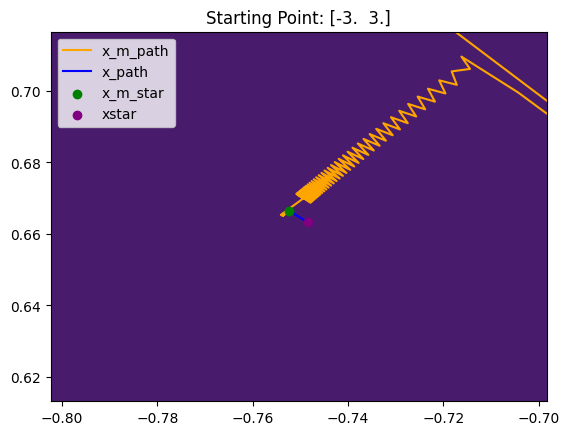

In [ ]:
print('xpath: ', xpath)
print()
print('lambpath: ', lambpath)

#plot the path
fig, ax = plt.subplots()


x1_range = np.linspace(-2, 2, num=200)
x2_range = np.linspace(-2, 2, num=200)

xx1, xx2 = np.meshgrid(x1_range, x2_range)
z = f([xx1, xx2])

ax.contourf(xx1, xx2, z)

ax.plot(x_m_path[:, 0], x_m_path[:, 1], color = 'orange', label = 'x_m_path')
ax.plot(xpath[:, 0], xpath[:, 1], color = 'blue', label = 'x_path')
#ax.plot(lambpath[:, 0], label = 'lambda')

# Mark the starting and ending points for x (red for start, purple for end)
ax.scatter(xstar_m[0], xstar_m[1], color='green', label='x_m_star', zorder=5)  # blue point for end of x with merit func
ax.scatter(xstar[0], xstar[1], color='purple', label='xstar', zorder=5)  # Purple point for end of x objective

zoom_padding = 0.05

# Select the last 5 points from both paths for zooming
x_m_last_points = x_m_path[-5:, 0], x_m_path[-5:, 1]
x_last_points = xpath[-5:, 0], xpath[-5:, 1]

# Get the min and max coordinates of the last points to focus the zoom
x_min = min(np.min(x_m_last_points[0]), np.min(x_last_points[0]))
x_max = max(np.max(x_m_last_points[0]), np.max(x_last_points[0]))
y_min = min(np.min(x_m_last_points[1]), np.min(x_last_points[1]))
y_max = max(np.max(x_m_last_points[1]), np.max(x_last_points[1]))

# Add padding for a better view around the last points
ax.set_xlim(x_min - zoom_padding, x_max + zoom_padding)
ax.set_ylim(y_min - zoom_padding, y_max + zoom_padding)

ax.set_title(f'Starting Point: {x0}')
plt.legend()


In the graph, we zoomed in on the area of convergence because the path from the optimal point of the merit function to the optimal point of the objective function was so small.

Testing with the same points that didn't converge earlier with just Newton descent...

For starting point  [-2  2] :


<ipython-input-13-46ad0b86f8d2>:3: RuntimeWarning: overflow encountered in scalar power
  return np.e ** (3*x[0]) + np.e ** (-4*x[1])


x_m*:  [-0.7524294   0.66654302]

x*:  [-0.74833549  0.66332043]
lamb*:  [[-0.21232494]]

xpath:  [[-0.7524294   0.66654302]
 [-0.74845021  0.66321129]
 [-0.74833607  0.66331979]
 [-0.74833549  0.66332043]]

lambpath:  [[-1.        ]
 [-0.21637056]
 [-0.212325  ]
 [-0.21232494]]



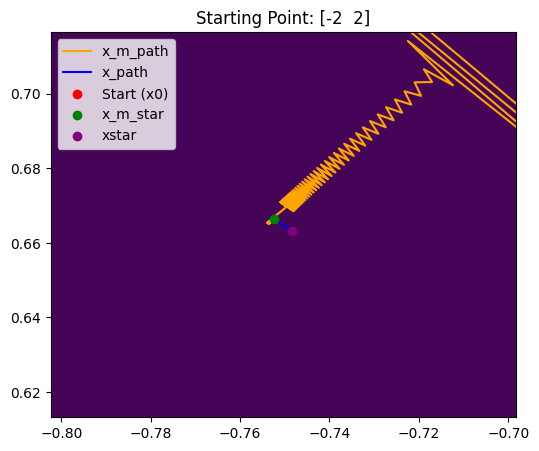

For starting point  [-1.5  1.5] :
x_m*:  [-0.75242945  0.66654298]

x*:  [-0.74833549  0.66332043]
lamb*:  [[-0.21232494]]

xpath:  [[-0.75242945  0.66654298]
 [-0.74845023  0.66321127]
 [-0.74833607  0.66331979]
 [-0.74833549  0.66332043]]

lambpath:  [[-1.        ]
 [-0.21637057]
 [-0.212325  ]
 [-0.21232494]]



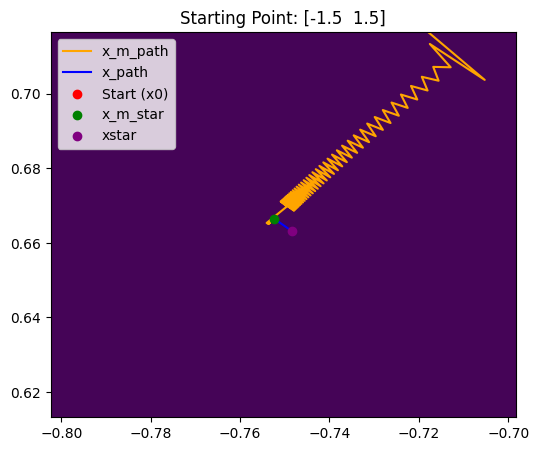

For starting point  [2 2] :
x_m*:  [-0.75242932  0.66654313]

x*:  [-0.74833549  0.66332043]
lamb*:  [[-0.21232494]]

xpath:  [[-0.75242932  0.66654313]
 [-0.74845016  0.66321135]
 [-0.74833607  0.66331979]
 [-0.74833549  0.66332043]]

lambpath:  [[-1.        ]
 [-0.21637057]
 [-0.212325  ]
 [-0.21232494]]



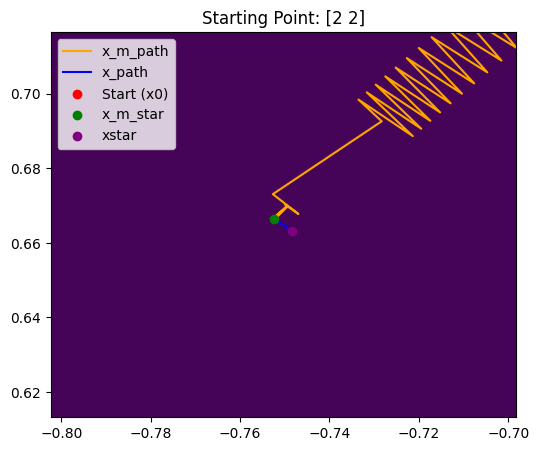

For starting point  [1 1] :
x_m*:  [-0.75242942  0.66654299]

x*:  [-0.74833549  0.66332043]
lamb*:  [[-0.21232494]]

xpath:  [[-0.75242942  0.66654299]
 [-0.74845022  0.66321128]
 [-0.74833607  0.66331979]
 [-0.74833549  0.66332043]]

lambpath:  [[-1.        ]
 [-0.21637056]
 [-0.212325  ]
 [-0.21232494]]



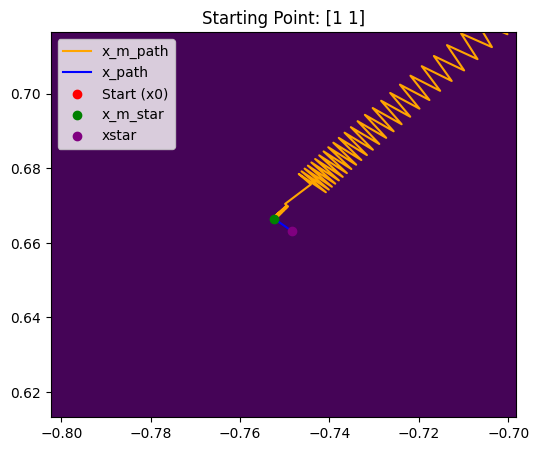

In [ ]:
#starting points
x0s = [np.array([-2, 2]),
       np.array([-1.5, 1.5]),
       np.array([2, 2]),
       np.array([1, 1])]

lamb0 = -1.
alpha = 1

for x0 in x0s:
  print('For starting point ', x0 ,':')
  xstar_m, x_m_path = backtracking_gradient_descent(x0, M, gradM, alpha_0=1)
  print('x_m*: ',xstar_m)
  print()
  xstar, lambstar, xpath, lambpath = newton_descent(xstar_m, lamb0, L, gradL, hessL, h, gradh, alpha_0=alpha)
  print('x*: ',xstar)
  print("lamb*: ",lambstar)
  print()
  print('xpath: ', xpath)
  print()
  print('lambpath: ', lambpath)
  print()

  # Plot the path
  fig, ax = plt.subplots(figsize=(6, 5))

  # Define the range for the contour plot
  x1_range = np.linspace(-2, 2, num=200)
  x2_range = np.linspace(-2, 2, num=200)

  xx1, xx2 = np.meshgrid(x1_range, x2_range)
  z = f([xx1, xx2])  # Evaluate the objective function on the grid

  # Contour plot of the objective function
  ax.contourf(xx1, xx2, z, levels=50, cmap="viridis")

  # Plot the paths
  ax.plot(x_m_path[:, 0], x_m_path[:, 1], color='orange', label='x_m_path')
  ax.plot(xpath[:, 0], xpath[:, 1], color='blue', label='x_path')

  # Mark the starting and ending points for x (red for start, purple for end)
  ax.scatter(x0[0], x0[1], color='red', label='Start (x0)', zorder=5)  # Red point for start of x
  ax.scatter(xstar_m[0], xstar_m[1], color='green', label='x_m_star', zorder=5)  # Green for end of x_m
  ax.scatter(xstar[0], xstar[1], color='purple', label='xstar', zorder=5)  # Purple point for end of x

  # Zoom in on the convergence region
  zoom_padding = 0.05  # Tight zoom padding

  # Select the last 5 points from both paths for zooming
  x_m_last_points = x_m_path[-5:, 0], x_m_path[-5:, 1]
  x_last_points = xpath[-5:, 0], xpath[-5:, 1]

  # Get the min and max coordinates of the last points to focus the zoom
  x_min = min(np.min(x_m_last_points[0]), np.min(x_last_points[0]))
  x_max = max(np.max(x_m_last_points[0]), np.max(x_last_points[0]))
  y_min = min(np.min(x_m_last_points[1]), np.min(x_last_points[1]))
  y_max = max(np.max(x_m_last_points[1]), np.max(x_last_points[1]))

  # Add padding for a better view around the last points
  ax.set_xlim(x_min - zoom_padding, x_max + zoom_padding)
  ax.set_ylim(y_min - zoom_padding, y_max + zoom_padding)

  ax.set_title(f'Starting Point: {x0}')
  plt.legend()
  plt.show()



Combining the optimization of the merit function using backtracking gradient descent and then applying Newton descent from the minimizer of the merit function, every starting point now converges to the solution of the objective function. yay